In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F



In [2]:
path_to_data = r'/Users/sooophias/Downloads/UW/599/finalproject/CSE599_data.pkl'
data = pd.read_pickle(path_to_data)
data = data.dropna()
data['date']

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sooophias/Downloads/UW/599/finalproject/CSE599_data.pkl'

In [739]:
no_stim_data = data[data['stim'] == 0]
oneday_data = no_stim_data[no_stim_data['date'] == '2021-11-15']
# temp_data = oneday_data[oneday_data['angle'] > 90
                        
# stim_data = data[data['stim'] == 1]
# stim_oneday_data = stim_data[stim_data['date'] == '2021-11-15']


names = data.columns

# stim_inputs =stim_oneday_data[names[3:]]
# stim_inputs = torch.tensor(stim_inputs.values).to(torch.float32)

pd_inputs = oneday_data[names[3:]]
inputs = torch.tensor(pd_inputs.values)
inputs = inputs.to(torch.float32)


angle_outputs = oneday_data['angle'].values
outputs = torch.zeros(angle_outputs.shape[0], 4, dtype = torch.long)



for i in range(angle_outputs.shape[0]):
    ind = angle_outputs[i]/90 -1
    outputs[i, int(ind)] = 1


ind_list = torch.argmax(outputs, dim = 1)
print(torch.sum(ind_list == 0))
print(torch.sum(ind_list == 1))
print(torch.sum(ind_list == 2))
print(torch.sum(ind_list == 3))


tensor(66)
tensor(58)
tensor(56)
tensor(59)


In [740]:
class RNN(nn.Module):
    def __init__(self, input_size,  hidden_size, output_size, nonlinearity = 'tanh'):

        super(RNN, self).__init__()
        #self.hidden_size = hidden_size[0]
        # self.layer1 = nn.Linear(input_size, hidden_size[0])
        #self.layer2 = nn.Linear(hidden_size[0], hidden_size[1])
        #self.layer3 = nn.Linear(hidden_size[1], output_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers = 5, nonlinearity = 'tanh')
        self.out_layer = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.Softmax(dim = 1)


    def forward(self, x):
        # rnn_out = torch.squeeze(rnn_out)
        # print(rnn_out.shape)

       # hidden1 = F.tanh(self.layer1(x))
        #hidden2 = F.tanh(self.layer2(hidden1))
        # hidden2 = F.tanh(self.layer2(hidden1))
        # output  = F.relu(self.layer3(hidden2))
        # = self.layer4(hidden3)

        #output = F.softmax(self.layer3(hidden2), dim = 1)
       
        hidden1, _ = self.rnn(x)
        output = self.out_layer(hidden1)
        output = self.logsoftmax(output)
       
        return  output, hidden1
    
    

    def initHidden(self):
        return torch.rand(1, self.hidden_size)
    
    

In [741]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [742]:
def train_model(model, loader, optimizer, loss_fn, epochs, threshold): 

    loss_list = []
    grad_list = []



    for epoch in range(epochs):
        total_loss = 0
        total_grad = 0
        prev_loss = 0
        for batch_idx, batch in enumerate(loader):
        
            inputs, target = batch
            optimizer.zero_grad()
            # print(input.shape)
        
            output, _ = model(inputs)
            # print(output.shape)
            loss = 0
            for l in range(output.shape[0]):
                loss+= loss_fn(output[l, :].double(), target[l, :].double())
            

            # loss = loss_fn(output, target)
            total_loss += loss.item()
            loss.backward()
            # grad = np.mean([p.grad.norm() for p in model.parameters()])
           

            # torch.nn.utils.clip_grad_norm_(model.parameters(), threshold)
            optimizer.step()

            if abs(prev_loss - loss) <= 1e-6:
                break
            else:
                prev_loss = loss

                
        if epoch % 500 == 0: 
            # print(epoch % 1000)
            print("Epoch:" + str(epoch))
            print("loss: " + str(loss.item()))
            

        loss_list.append(total_loss / len(loader))


    return loss_list, model

In [745]:
def test_model(model, inputs, targets):

    outputs, _ = model(inputs)
    # print(outputs)
    pred = torch.argmax(outputs, dim = 1)
    # print(pred)
    targets_pos = torch.argmax(targets, dim = 1)

    pred_acc = torch.sum(pred == targets_pos) / inputs.shape[0]
    


    return pred_acc, targets_pos, pred



In [746]:
input_size = 168
output_size = 4
hidden_size = 55
learning_rate = 1e-4
decay = 0.1
batch_size = 10
net =  RNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = nn.CrossEntropyLoss()
dataset = MyDataset(inputs, outputs)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True) # 



In [747]:
epochs = 2000
threshold = 1
avg_loss, net = train_model(net, loader, optimizer, loss_fn, epochs, threshold)


Epoch:0
loss: 12.394630486770158
Epoch:500
loss: 7.865603263692609
Epoch:1000
loss: 6.862852115703639
Epoch:1500
loss: 6.89549658456317


Text(0, 0.5, 'Average Loss')

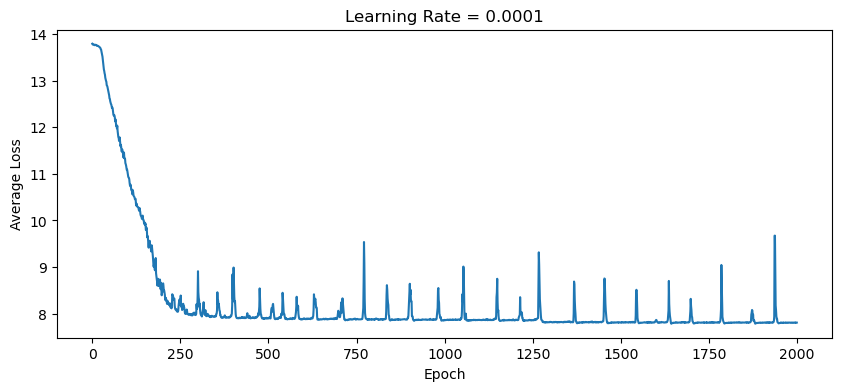

In [748]:
plt.figure(figsize=(10, 4))
plt.title("Learning Rate = " + str(learning_rate))

plt.plot(avg_loss)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")


# plt.show()

# plt.savefig("loss_n_grad_lr_" + str(learning_rate)+".png")

In [749]:
def prediction_details(pred, target, pred_acc):
    matrix = np.zeros((4, 4))
    for i in range(pred.shape[0]):
        matrix[pred[i], target[i]] += 1
    print(matrix)
    matrix = matrix / np.sum(matrix, 1)
    plt.figure
    plt.title("Prediciton accuracy = " + str(round(pred_acc.item(), 3)))
    plt.imshow(matrix)
    
    plt.colorbar()

        

tensor(0.9791)
[[65.  0.  0.  2.]
 [ 0. 56.  0.  0.]
 [ 1.  1. 56.  0.]
 [ 0.  1.  0. 57.]]
tensor([3, 2, 2, 3, 1, 0, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 0, 1, 2, 3, 1, 0, 2, 2,
        0, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 3, 1, 1, 1, 0, 1, 2, 3, 3, 2,
        0, 3, 3, 3, 2, 2, 1, 2, 3, 0, 1, 0, 2, 3, 2, 3, 1, 1, 1, 3, 0, 0, 3, 1,
        0, 2, 2, 3, 1, 2, 1, 3, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 1, 0, 3, 1, 0,
        2, 0, 3, 0, 3, 1, 2, 2, 3, 0, 1, 3, 2, 1, 0, 2, 0, 3, 0, 2, 2, 1, 3, 3,
        1, 0, 2, 2, 3, 1, 0, 2, 1, 3, 0, 0, 3, 1, 2, 0, 3, 0, 2, 1, 0, 2, 2, 3,
        0, 0, 1, 1, 0, 0, 2, 2, 1, 0, 1, 3, 0, 2, 3, 3, 3, 1, 2, 0, 3, 3, 3, 0,
        2, 0, 1, 0, 1, 3, 1, 3, 0, 1, 0, 2, 3, 1, 0, 3, 1, 3, 2, 3, 3, 3, 2, 3,
        3, 1, 2, 3, 3, 3, 2, 3, 3, 1, 2, 0, 2, 3, 0, 1, 1, 2, 3, 0, 3, 0, 1, 1,
        1, 2, 0, 2, 0, 3, 1, 0, 0, 0, 2, 2, 0, 1, 2, 1, 1, 0, 0, 3, 3, 0, 3])
tensor([[0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],


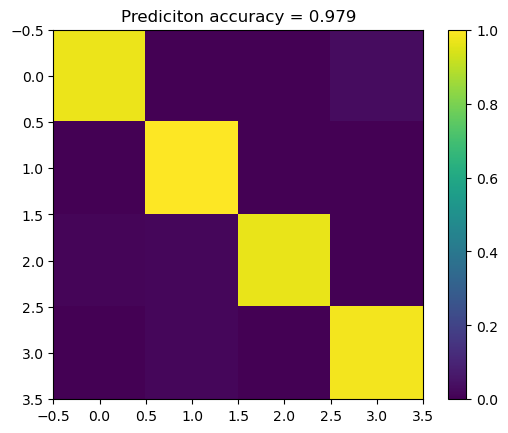

In [750]:
pred_acc, target_pos, pred = test_model(net, inputs, outputs)
print(pred_acc)
prediction_details(pred, target_pos, pred_acc)
# plt.savefig("prediction_accuracy.png")
print(target_pos)
print(outputs)

In [751]:
pred_output_state, hidden_states = net(inputs)

In [752]:
# use LDA to find two hidden units that best separate the four classes
output_ind = torch.argmax(outputs, dim = 1).detach().numpy()
unit1 = 0
unit2 = 0
max_acc = 0
n_hidden_units = hidden_states.shape[1]
for k in range(n_hidden_units-1):
    for j in range(k+1, n_hidden_units):
        clf = LDA()
        units = hidden_states[:, [k, j]].detach().numpy()
        clf.fit(units,  output_ind)
        lda_pred = clf.predict(units)
        lda_acc = np.sum(lda_pred == output_ind)/output_ind.shape[0]
        if lda_acc > max_acc:
            unit1 = k
            unit2 = j
            max_acc = lda_acc


<function matplotlib.pyplot.show(close=None, block=None)>

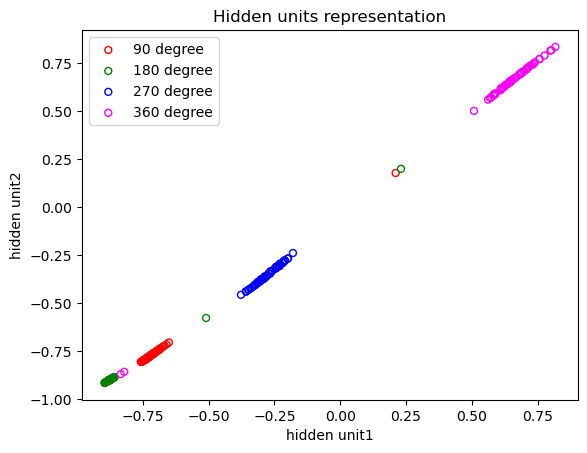

In [753]:
hidden_states.shape
plt.figure
hiddens = hidden_states.detach().numpy()

output_ind = torch.argmax(outputs, dim = 1).detach().numpy()
color_list = ['red', 'green', 'blue', 'magenta']
for label in range(4):
    ind = output_ind == label
    plt.scatter(hiddens[ind, unit1], hiddens[ind, unit2], s = 25, facecolors='none', edgecolors=color_list[label])
    plt.legend(["90 degree", "180 degree", "270 degree", "360 degree"])
    plt.xlabel("hidden unit1")
    plt.ylabel("hidden unit2")
    plt.title("Hidden units representation")
plt.show
#plt.savefig("hidden_unit_rep.png")
